<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/uniapprox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks as Universal Approximators
By Fayyaz Minhas


A single hidden layer neural network can be a [universal function approximator](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Here, we write a simple code to test this. We have a single hidden layer neuron in which there are $P$ neurons, each with sigmoidal activation function. The objective is to find the weights of each of the inputs so that the weighted summation of the outputs of the P neurons give a good approximation of the given function.

## Universal approximation thereom
Any function $y(x)$ over $x \in R^m$ can be represented (or approximated) (with bounded error $|g(x)-h(x)|<\epsilon$) as follows:
$$\hat{y}(x)=\sum_{i=1}^P v_ia(w_i^Tx+b_i)+v_0$$

Here:

* $a(\cdot)$ is a non-constant, bounded and monotonically-increasing continuous “basis” or activation function

* P is the number of functions (hidden neurons)



100%|██████████| 1000/1000 [00:01<00:00, 586.73it/s]


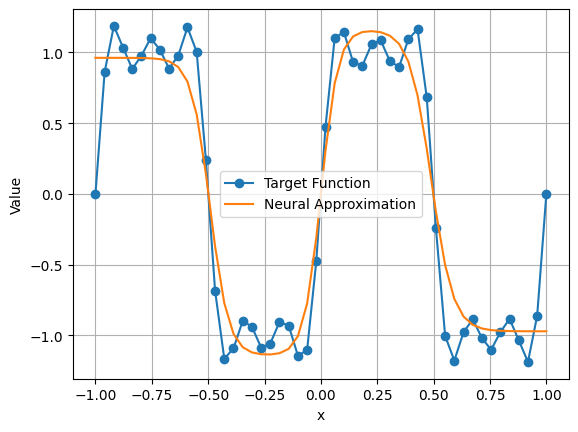

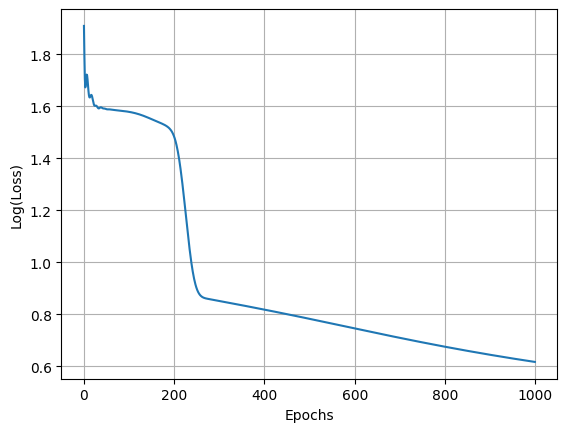

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
# Function to approximate
def target_function(t):
    #return np.sin(4 * t) + np.cos(10 * t)
    f = np.zeros_like(x)  # Initialize the square wave
    N_terms = 3
    A = 1.0
    T = 1.0
    f = np.zeros_like(t)  # Initialize the square wave
    for n in range(1, 2 * N_terms, 2):  # Only odd terms
        f += (4 * A / np.pi) * np.sin(2 * np.pi * n * t / T) / n
    return f

# Generate data
x_values = np.linspace(-1, 1, 50)
y_values = target_function(x_values)

# Convert to PyTorch tensors
x_tensor = torch.from_numpy(np.atleast_2d(x_values).T).float()
y_tensor = torch.from_numpy(y_values).float()

# Network configuration
input_size = 1
output_size = 1
hidden_neurons = 3  # Adjust this to see how the approximation improves


# Initialize hidden layer weights and biases (Xavier)
w = torch.randn((hidden_neurons, input_size)) * np.sqrt(2. / (input_size + hidden_neurons))
b = torch.randn(hidden_neurons)  # Biases can be initialized to zero

# Initialize output layer weights and biases (Xavier)
v = torch.randn(hidden_neurons) * np.sqrt(2. / (hidden_neurons + output_size))
v0 = torch.randn(1)  # Single bias for the output layer

# Enable gradient tracking
w.requires_grad_(True)
b.requires_grad_(True)
v.requires_grad_(True)
v0.requires_grad_(True)


# Representation: Neural network approximation function
def neural_approximator(x):
    z = torch.sigmoid(x @ w.T + b)
    output = z @ v + v0
    return output
# Training configuration
learning_rate = 1e-1
epochs = 1000
optimizer = optim.Adam([w, b,v,v0], lr=learning_rate)
loss_history = []

# Training loop
for epoch in tqdm(range(epochs)):
    #Representation
    approximation = neural_approximator(x_tensor)
    # Evaluation
    loss = torch.sum((approximation - y_tensor) ** 2)
    # Optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.item())
# Plot the target function and its neural approximation
plt.figure()
plt.plot(x_values, y_values, 'o-', label='Target Function')
plt.plot(x_values, neural_approximator(x_tensor).detach().numpy(), label='Neural Approximation')
plt.xlabel('x')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.show()

# Plot loss history
plt.figure()
plt.plot(np.log10(loss_history))
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.grid()
plt.show()


Let's see how the function can be represented as a summation of sigmoids. Isn't it strange that a function like the one given above can be represented in terms of such sigmoids?

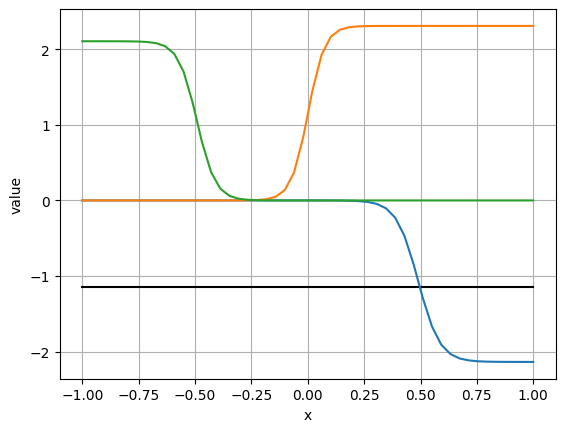

In [63]:
plt.figure();
x = x_tensor
plt.plot(x,[float(v0[0].detach().numpy())]*len(x),'k')
plt.plot(x,(v*torch.sigmoid(x@w.T+b)).detach().numpy())
plt.xlabel('x');plt.ylabel('value');plt.grid();


Below is a more pytorch style neural network looking implementation of the same thing:

100%|██████████| 1000/1000 [00:00<00:00, 1134.40it/s]


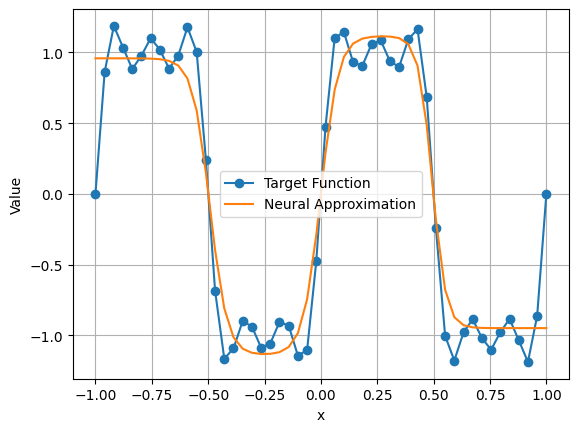

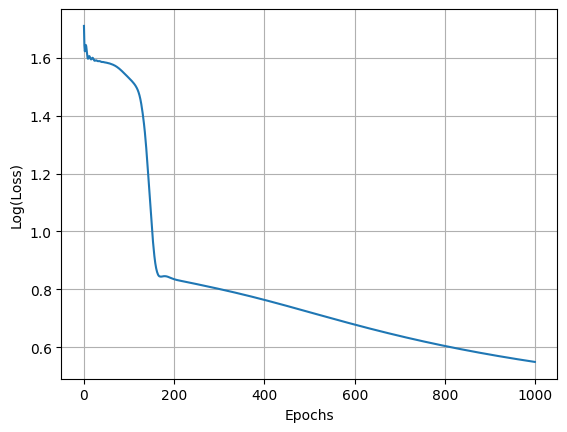

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Define the neural network architecture as a class
model = nn.Sequential(
            nn.Linear(input_size, hidden_neurons),  # Input layer to hidden layer
            nn.Sigmoid(),                           # Non-linearity
            nn.Linear(hidden_neurons, output_size), # Output layer
        )
# Training configuration
learning_rate = 1e-1
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []

# Training loop
for epoch in tqdm(range(epochs)):
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass
    approximation = model(x_tensor)
    # Compute loss
    loss = torch.sum((approximation.squeeze() - y_tensor) ** 2)  # Ensure approximation is squeezed to match y_tensor's shape
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()
    # Record loss history
    loss_history.append(loss.item())
plt.figure()
plt.plot(x_values, y_values, 'o-', label='Target Function')
plt.plot(x_values, model(x_tensor).detach().numpy(), label='Neural Approximation')
plt.xlabel('x')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.show()
# Plot loss history
plt.figure()
plt.plot(np.log10(loss_history))
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.grid()
plt.show()

To do:
1. What is the impact of the number of neurons P?
2. Can you approximate any function?
3. What happens if we add another layer?